Example from

https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html


https://github.com/marcotcr/lime/tree/master/doc/notebooks

and *Deep Learning with Python*, Chapter 6.

Bug solved here: https://github.com/marcotcr/lime/issues/236


In [1]:
# ensure plots print without needing to call show()
%matplotlib inline

In [2]:
# import our packages
import pandas
import numpy
import os
import gzip
import sys
import pickle
import textwrap

import seaborn
import wvpy.util

import sklearn.metrics
from sklearn.pipeline import make_pipeline

In [3]:
# set up Keras imports, this can be brittle
# no longer import keras, import tensorflow.keras
import tensorflow.keras as keras
# https://github.com/keras-team/keras/issues/12379#issuecomment-473823330
from tensorflow.keras import *
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
from tensorflow.keras.layers import *
#from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
#from keras.models import Model
#from keras.optimizers import RMSprop
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
from tensorflow.keras.optimizers import *

In [4]:
# get our data and language model through data adaptors
sys.path.append('.')
# put data load on our path
sys.path.append('../data/IMDB')
from load_IMDB import load_IMDB


In [5]:
# load the IMDB data
train_data, test_data = load_IMDB()

In [6]:
(train_data.data[5], train_data.target[5])

("I would put this at the top of my list of films in the category of unwatchable trash! There are films that are bad, but the worst kind are the ones that are unwatchable but you are suppose to like them because they are supposed to be good for you! The sex sequences, so shocking in its day, couldn't even arouse a rabbit. The so called controversial politics is strictly high school sophomore amateur night Marxism. The film is self-consciously arty in the worst sense of the term. The photography is in a harsh grainy black and white. Some scenes are out of focus or taken from the wrong angle. Even the sound is bad! And some people call this art?<br /><br />",
 0)

In [7]:
(test_data.data[5], test_data.target[5])

("I had high hopes for this one until they changed the name to 'The Shepherd : Border Patrol, the lamest movie name ever, what was wrong with just 'The Shepherd'. This is a by the numbers action flick that tips its hat at many classic Van Damme films. There is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame. There is one great line about 'being p*ss drunk and carrying a rabbit' and some OK action scenes let down by the cheapness of it all. A lot of the times the dialogue doesn't match the characters mouth and the stunt men fall down dead a split second before even being shot. The end fight is one of the better Van Damme fights except the Director tries to go a bit too John Woo and fails also introducing flashbacks which no one really cares about just gets in the way of the action which is the whole point of a van Damme film.<br /><br />Not good, not bad, just average generic action.",
 0)

## Training a classifier

Let's tokenize the data.

In [8]:
vocab_size = 10000
max_len = 300
embed_dim = 24

tok = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
# all fitting, including tokenizers is done only on training data
tok.fit_on_texts(train_data.data)

# shuffle rows of training data in case neural net batching takes in ordered chunks
permutation = numpy.random.choice(len(train_data.data), size=len(train_data.data), replace=False)
train_data_shuffled = [train_data.data[i] for i in permutation]
train_target_shuffled = [train_data.target[i] for i in permutation]

# convert training data
train_text = tok.texts_to_sequences(train_data_shuffled)
train_text = keras.preprocessing.sequence.pad_sequences(
    train_text, maxlen=max_len,
    padding="post", truncating="post")
train_target = numpy.asarray(train_target_shuffled, dtype=float)

# convert test data
test_text = tok.texts_to_sequences(test_data.data)
test_text = keras.preprocessing.sequence.pad_sequences(
    test_text, maxlen=max_len,
    padding="post", truncating="post")
test_target = numpy.asarray(test_data.target, dtype=float)

We now define our neural net.



In [9]:
# define our neural net
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length = max_len))
model.add(Bidirectional(LSTM(64)))  # or model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

2022-04-05 13:37:54.826023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 24)           240000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              45568     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 285,697
Trainable params: 285,697
Non-trainable params: 0
_________________________________________________________________


Save the initial state of the model, this lets us re-train. Having to pick the epoch and re-trian in this way is a bit non-standard and is evidence we are running this example on too little data and/or haven't taken enough precautions against over-fit (such as drop-out layers). Usually more epochs is better.

In [10]:
wts = model.get_weights()

In [11]:
history = model.fit(
    train_text, 
    train_target, 
    epochs=20,
    batch_size=256, 
    validation_split=0.2)

Epoch 1/20
79/79 [==============================] - 51s 606ms/step - loss: 0.6388 - acc: 0.6378 - val_loss: 0.5812 - val_acc: 0.7648
Epoch 2/20
79/79 [==============================] - 49s 623ms/step - loss: 0.4350 - acc: 0.8233 - val_loss: 0.3887 - val_acc: 0.8440
Epoch 3/20
79/79 [==============================] - 47s 590ms/step - loss: 0.3263 - acc: 0.8741 - val_loss: 0.3754 - val_acc: 0.8692
Epoch 4/20
79/79 [==============================] - 47s 593ms/step - loss: 0.2702 - acc: 0.8972 - val_loss: 0.3644 - val_acc: 0.8662
Epoch 5/20
79/79 [==============================] - 46s 579ms/step - loss: 0.2394 - acc: 0.9100 - val_loss: 0.3310 - val_acc: 0.8790
Epoch 6/20
79/79 [==============================] - 46s 583ms/step - loss: 0.2156 - acc: 0.9224 - val_loss: 0.4272 - val_acc: 0.8642
Epoch 7/20
79/79 [==============================] - 46s 583ms/step - loss: 0.2122 - acc: 0.9243 - val_loss: 0.4238 - val_acc: 0.8680
Epoch 8/20
79/79 [==============================] - 47s 590ms/step - 

In [12]:
training_trajectory = pandas.DataFrame(history.history)
training_trajectory

,loss,acc,val_loss,val_acc
0,0.638800,0.63785,0.581218,0.7648
1,0.435049,0.82330,0.388663,0.8440
2,0.326255,0.87410,0.375393,0.8692
3,0.270186,0.89725,0.364353,0.8662
4,0.239385,0.91000,0.331014,0.8790
5,0.215625,0.92240,0.427226,0.8642
6,0.212178,0.92425,0.423838,0.8680
7,0.184396,0.93485,0.828424,0.7682
8,0.167364,0.94310,0.415904,0.8458
9,0.152147,0.94670,0.360813,0.8748


<AxesSubplot:>

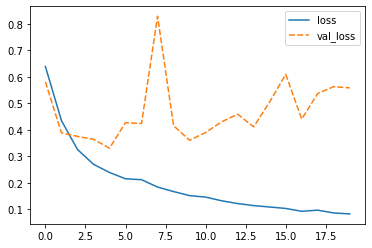

In [13]:
seaborn.lineplot(data = training_trajectory[['loss', 'val_loss']])

In [14]:
best_epoch_id = training_trajectory.val_loss.idxmin()
best_epoch_id

4

The early divergence of the train and validation curves is a bad sign.

For this data set a small epochs is pretty good (using validation loss as the criterion).

This is a stong sign of not having enough data for the task of learning the language model/embedding.

We will re-run to an early stage and look at our results.

In [15]:
model.set_weights(wts)
model.fit(
    train_text, 
    train_target, 
    epochs=best_epoch_id + 1,
    batch_size=256, 
    validation_split=0.2)

Epoch 1/5
79/79 [==============================] - 46s 587ms/step - loss: 0.6928 - acc: 0.5110 - val_loss: 0.6933 - val_acc: 0.4826
Epoch 2/5
79/79 [==============================] - 48s 602ms/step - loss: 0.6159 - acc: 0.6872 - val_loss: 0.4921 - val_acc: 0.8150
Epoch 3/5
79/79 [==============================] - 47s 591ms/step - loss: 0.4373 - acc: 0.8211 - val_loss: 0.4866 - val_acc: 0.7940
Epoch 4/5
79/79 [==============================] - 45s 571ms/step - loss: 0.3620 - acc: 0.8597 - val_loss: 0.4120 - val_acc: 0.8176
Epoch 5/5
79/79 [==============================] - 46s 576ms/step - loss: 0.2914 - acc: 0.8924 - val_loss: 0.4446 - val_acc: 0.8124


In [16]:
# Tensorflow now implements .predict_proba() as .predict()
preds_train = pandas.DataFrame(model.predict(train_text))
preds_train.columns = ["prediction"]
preds_train["actual"] = train_target


In [17]:
preds_test = pandas.DataFrame(model.predict(test_text))
preds_test.columns = ["prediction"]
preds_test["actual"] = test_target


<Figure size 432x288 with 0 Axes>

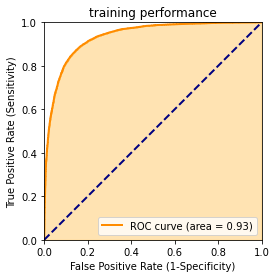

0.9348840064

In [18]:
wvpy.util.plot_roc(
    preds_train["prediction"],
    preds_train["actual"],
    title='training performance')

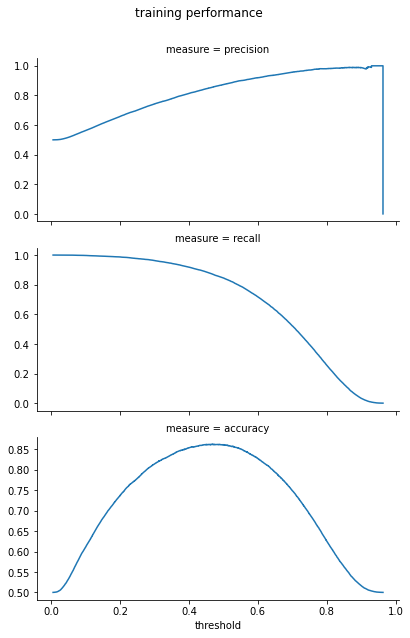

In [19]:
wvpy.util.threshold_plot(
    preds_train,
    pred_var="prediction",
    truth_var="actual",
    plotvars=('precision', 'recall', 'accuracy'),
    title='training performance',
)

In [20]:
# estimate accuracy on train
numpy.mean((preds_train.actual >= 0.5) == (preds_train.prediction >= 0.5))


0.86144

<Figure size 432x288 with 0 Axes>

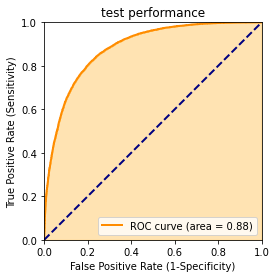

0.8831210272000001

In [21]:
wvpy.util.plot_roc(
    preds_test["prediction"],
    preds_test["actual"],
    title='test performance')

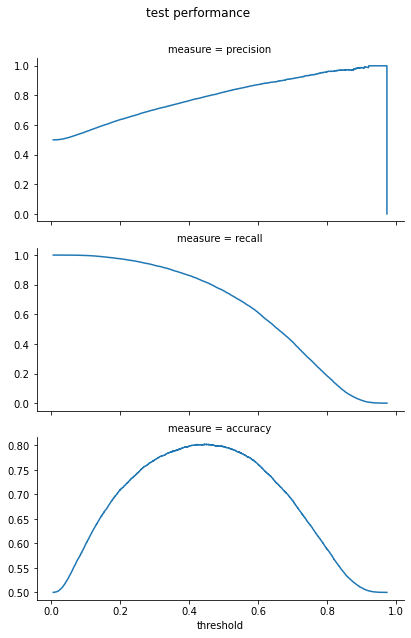

In [22]:
wvpy.util.threshold_plot(
    preds_test,
    pred_var="prediction",
    truth_var="actual",
    plotvars=('precision', 'recall', 'accuracy'),
    title='test performance',
)

In [23]:
# estimate accuracy on test
numpy.mean((preds_test.actual >= 0.5) == (preds_test.prediction >= 0.5))


0.79748

In [24]:
# accuracy at another threshold
numpy.mean((preds_test.actual >= 0.3) == (preds_test.prediction >= 0.3))

0.77008